## PDB analysis example

In this example, we will analyse crystal structures of Vitamin D receptor of three different species - human (hVDR), rat (rVDR) and zebrafish (zVDR). All the structures were downloaded from Protein Data Bank and refined with Maestro (Schrodinger, LLC).

In [ ]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import export_text
from sklearn.tree import plot_tree
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.io as pio

import seaborn as sns
from matplotlib import pyplot as plt

Let's first load our data.

In [ ]:
# will add datasets to 'example' directory and remove this line

# load PDB data
df_h = pd.read_csv('test_data/output_data/test-pdbprep-human.csv', sep=',', decimal='.')
df_z = pd.read_csv('test_data/output_data/test-pdbprep-zebrafish.csv', sep=',', decimal='.')
df_r = pd.read_csv('test_data/output_data/test-pdbprep-rat.csv', sep=',', decimal='.')

In [ ]:
# add labels

df_h['label'] = 'human'
df_z['label'] = 'zebrafish'
df_r['label'] = 'rat'

In [ ]:
df_h.head()

,Unnamed: 0,Entry ID,Dist prot-H1,Dist prot-H2,Dist prot-H3,Dist prot-H4,Dist prot-H5,Dist prot-H6,Dist prot-H7,Dist prot-H8,...,DSSP end_H6,DSSP end_H7,DSSP end_H8,DSSP end_H9,DSSP end_H10,DSSP end_H11,DSSP end_H12,DSSP end_H13,N_res extra helical,label
0,0,1DB1,17.383401,19.165445,9.335281,17.702364,4.166875,20.690995,14.662196,11.275732,...,379,396,397,405,0,0,416,421,13,human
1,1,1IE8,17.357873,19.127866,9.301396,17.515951,4.182090,20.480177,14.527983,11.256915,...,378,396,397,405,410,413,416,421,7,human
2,2,1IE9,17.326587,19.222460,9.487590,17.786285,4.308967,20.691590,14.665609,11.114064,...,379,396,397,405,410,413,416,422,7,human
3,3,1S0Z,17.396076,19.177460,9.325881,17.672507,4.135920,20.675115,14.648609,11.252090,...,379,396,397,405,0,0,416,421,13,human
4,4,1S19,17.407821,19.137370,9.334699,17.819448,4.114692,20.698929,14.854570,11.259176,...,379,396,397,405,0,0,416,422,13,human


Then we need to indicate a reference for helices in our proteins. Descriptors package uses KPAX (Ritchie et. al., 2016) to find the consensus secondary strcuture sequence for each species, so we can indicate the references obtained with this software.

In [ ]:
href = np.array([[127,142], [149,152], [226,246], [257,265], [268, 278], [298,302], [308,322], [328,338], [350,369], [379,396], [397,406], [411,413], [417,423]]).flatten()
zref = np.array([[159,174], [181, 184], [254,274], [285, 293], [295,303], [326, 330], [336,350], [356,366], [378,397], [405,422], [423, 432], [435,439], [443, 447]]).flatten()
rref = np.array([[127,142], [149,152], [222,242], [253,262], [263, 273], [294,298], [304,318], [324,334], [346,365], [376,392], [393,402], [405,409], [413,418]]).flatten()

Then we can perform some general operations to preprocess our data before the analysis (these operations will be further included into a package).

In [ ]:
# general function for transforming DSSP descriptors into DSSP-ref difference

def deltaTransform(x, ref):
  for i in range(len(x)):
    if i%2 == 0:
      x.iloc[i] = (ref[i]-x.iloc[i])
    else:
      x.iloc[i] = (x.iloc[i]-ref[i])
  return x

In [ ]:
# general function for checking if there are cols with the same values (so that they can be deleted)

def unique_cols(df):
    a = df.to_numpy()
    return (a[0] == a).all(0)

In [ ]:
cols = np.array(df_h.filter(regex=("DSSP")).columns)
df_h[cols] = df_h[cols].apply(lambda x: deltaTransform(x, href), axis=1)
df_z[cols] = df_h[cols].apply(lambda x: deltaTransform(x, zref), axis=1)
df_r[cols] = df_h[cols].apply(lambda x: deltaTransform(x, rref), axis=1)

A very important step is to scale our data, as descriptors have different values. 

We have a choice - either to scale each dataframe separately and then merge them altogether for further analysis, or to merge them in advance before scaling. In the following examples you'll see, what is the difference and why both these methods can be of use.

### Dividing data by species (scaling of merged data)

Let's first try merging the data prior to scaling procedure.

In [ ]:
# merging data

pdList = [df_h, df_z, df_r]
df = pd.concat(pdList)
df = df.reset_index()
df_ids = df['Entry ID']
df_labels = df['label']

In [ ]:
# deleting same values

idx,  = np.where(unique_cols(df) == True)
same_vals = df.iloc[:, idx].columns.tolist()
delete_list = same_vals.copy()
delete_list.extend(['index','Entry ID', 'label'])
df_transformed = df.drop(delete_list, axis=1)

df_transformed

,Unnamed: 0,Dist prot-H1,Dist prot-H2,Dist prot-H3,Dist prot-H4,Dist prot-H5,Dist prot-H6,Dist prot-H7,Dist prot-H8,Dist prot-H9,...,DSSP end_H5,DSSP end_H6,DSSP end_H7,DSSP end_H8,DSSP end_H9,DSSP end_H10,DSSP end_H11,DSSP end_H12,DSSP end_H13,N_res extra helical
0,0,17.383401,19.165445,9.335281,17.702364,4.166875,20.690995,14.662196,11.275732,21.761630,...,1,0,0,0,-1,411,-413,1,-2,13
1,1,17.357873,19.127866,9.301396,17.515951,4.182090,20.480177,14.527983,11.256915,21.546327,...,-2,1,0,0,-1,1,0,1,-2,7
2,2,17.326587,19.222460,9.487590,17.786285,4.308967,20.691590,14.665609,11.114064,21.512406,...,1,0,0,0,-1,1,0,1,-1,7
3,3,17.396076,19.177460,9.325881,17.672507,4.135920,20.675115,14.648609,11.252090,21.691169,...,1,0,0,0,-1,411,-413,1,-2,13
4,4,17.407821,19.137370,9.334699,17.819448,4.114692,20.698929,14.854570,11.259176,21.700242,...,1,0,0,0,-1,411,-413,1,-1,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,38,17.410781,18.368902,8.607509,15.193668,5.675648,20.008659,15.043807,11.720919,22.185664,...,-365,376,-392,393,-403,404,-409,412,-419,6
121,39,17.731370,18.322119,8.397427,15.344835,5.399476,20.397335,15.219482,11.751922,22.863806,...,-364,376,-392,393,-403,404,-409,412,-419,0
122,40,17.427492,18.280603,8.535653,15.211494,5.522957,20.554226,15.202210,11.717984,22.116914,...,-364,376,-392,393,-403,405,-409,412,-419,6
123,41,17.645046,18.171696,8.415075,15.357376,5.411821,20.461276,15.283861,11.803370,22.825317,...,-364,376,-392,393,-403,-6,-822,412,-419,6


In [ ]:
# apply scaling
scaler = preprocessing.StandardScaler()
scaled_values = scaler.fit_transform(df_transformed)
scaled_df = pd.DataFrame(scaled_values, columns=df_transformed.columns)

In [ ]:
# apply PCA

pca_values = PCA(n_components=3).fit_transform(scaled_df)
pca_df = pd.DataFrame()
pca_df['X'] = pca_values[:,0]
pca_df['Y'] = pca_values[:,1]
pca_df['Z'] = pca_values[:,2]
pca_df['ID'] = df_ids
pca_df['label'] = df_labels

In [ ]:
pca_df

,X,Y,Z,ID,label
0,13.393719,-1.432241,-1.458124,1DB1,human
1,13.700249,-1.230636,-0.986701,1IE8,human
2,14.366856,-1.001874,-1.510902,1IE9,human
3,13.560700,-1.433355,-1.231292,1S0Z,human
4,13.287306,-1.311996,-1.793710,1S19,human
...,...,...,...,...,...
120,-8.023296,-9.385318,0.611463,3W5P,rat
121,-9.090878,-8.175452,-1.258547,5XPM,rat
122,-8.344503,-8.805674,-0.806587,5XPN,rat
123,-8.597701,-9.670439,-0.670527,5XPO,rat


In [ ]:
pio.templates.default = "simple_white"

fig = px.scatter(pca_df, 
                 x = 'X', 
                 y = 'Y',
                 opacity = 0.8,
                 color='label', 
                 hover_data=['ID'],
                 color_discrete_sequence=px.colors.qualitative.Vivid,
                 title="PDB structures (merged)",
                 width=600, height=500)

fig.update_traces(marker={'size': 10})
fig.show()

We can see that using this approach we are able to divide data according to species as we merged the data and let the scaler learn the information about the range of all descriptors values that might be species-specific.

**Note:** if we plot these data using 3D projection, we will see **one strong outlier in human dataset**, which is 3AZ3. This structure contains modified residues in region 290-300. The 3D projection is not shown, but you can try by yourself or just to wait for the next part of the analysis - there we have some plots demonstarating this outlier's nature. But we mention it also here because we want to remove it prior to building species profile. 

In [ ]:
# prepare data

df_pl = scaled_df.copy()
df_pl['label'] = df_labels
df_pl['ID'] = df_ids
df_pl = df_pl[df_pl.ID!='3AZ3']

polar=df_pl.groupby("label").mean().reset_index()
polar=pd.melt(polar,id_vars=["label"])

In [ ]:
fig = px.line_polar(polar, 
                    r="value", theta="variable", 
                    color="label", line_close=True,
                    title="Species profiles",
                    height=800,width=800)

fig.update_layout(template='plotly',
                  showlegend=True,
                  polar = dict(
                      radialaxis = dict(showticklabels=False, ticks=''),
                      angularaxis = dict(showticklabels=False, ticks='')
                      ))

fig.show()

We can also try Decision tree Classifier to figure out the rules that are important in dividing the groups.

In [ ]:
# decision tree 3 classes (species)

X = scaled_df.to_numpy()
y = pca_df['label'].to_numpy()

feature_names = scaled_df.columns
names = ['human', 'rat', 'zebrafish']

clf = DecisionTreeClassifier(random_state=42)
clf = clf.fit(X, y)

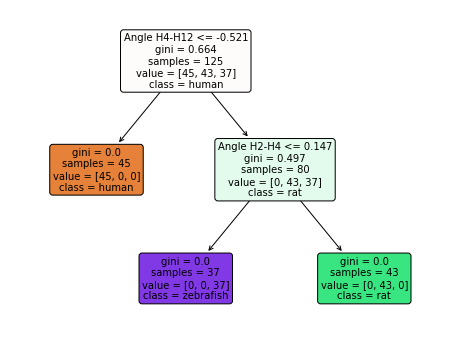

In [ ]:
plt.figure(figsize=(8,6))
plot_tree(clf, filled=True, rounded=True, fontsize=10, feature_names=feature_names, class_names=names)
None

In [ ]:
cv = LeaveOneOut()

plots = list()
y_true, y_pred = list(), list()

for train_ix, test_ix in cv.split(X):
  X_train, X_test = X[train_ix, :], X[test_ix, :]
  y_train, y_test = y[train_ix], y[test_ix]
  model = DecisionTreeClassifier(random_state=42, min_samples_leaf=1)
  model.fit(X_train, y_train)

  yhat = model.predict(X_test)
  
  y_true.append(y_test[0])
  y_pred.append(yhat[0])

acc = accuracy_score(y_true, y_pred)
print('Accuracy: %.3f' % acc)

Accuracy: 1.000


In [ ]:
# decision tree 2 classes (has coa / no coa)

coa_labels = list()

for index, row in pca_df.iterrows():
  if row['ID'] in ['6XZV', '6XZI', '6XZH', '6XZK','6XZJ'] or row['label'] == 'human':
    coa_labels.append(0)
  else:
    coa_labels.append(1)

X = scaled_df.to_numpy()
y = np.array(coa_labels)

feature_names = scaled_df.columns
names = ['no coa', 'coa']

clf = DecisionTreeClassifier(random_state=42)
clf = clf.fit(X, y)

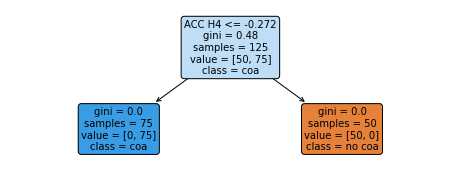

In [ ]:
plt.figure(figsize=(8,3))
plot_tree(clf, filled=True, rounded=True, fontsize=10, feature_names=feature_names, class_names=names)
None

In [ ]:
cv = LeaveOneOut()

y_true, y_pred = list(), list()

for train_ix, test_ix in cv.split(X):
  X_train, X_test = X[train_ix, :], X[test_ix, :]
  y_train, y_test = y[train_ix], y[test_ix]
  model = DecisionTreeClassifier(random_state=42, min_samples_leaf=1)
  model.fit(X_train, y_train)

  yhat = model.predict(X_test)
  
  y_true.append(y_test[0])
  y_pred.append(yhat[0])

acc = accuracy_score(y_true, y_pred)
print('Accuracy: %.3f' % acc)

Accuracy: 0.992


### Finding common dependincies outside species (scaling datasets separately)

Now let's try to scale each dataset separately.

In [ ]:
data = {'df_h': df_h, 
        'df_r': df_r, 
        'df_z': df_z,
        }

In [ ]:
transformed_data = dict()

for name, df in data.items():
  temp_df = df.copy()
  idx,  = np.where(unique_cols(df) == True)
  same_vals = df.iloc[:, idx].columns.tolist()
  delete_list = same_vals.copy()
  delete_list.extend(['Entry ID', 'label'])
  temp_df = temp_df.drop(delete_list, axis=1)
  transformed_data.update({name:temp_df})

In [ ]:
# apply scaling

scaled_data = dict()
scaler = preprocessing.StandardScaler()

for name, df in transformed_data.items():
  scaled_values = scaler.fit_transform(df)
  scaled_df = pd.DataFrame(scaled_values, columns=transformed_data[name].columns)
  scaled_data.update({name:scaled_df})

In [ ]:
# apply PCA

pca_data = dict()

for name, df in scaled_data.items():
  temp_pca = PCA(n_components=3).fit_transform(df)
  pca_df = pd.DataFrame()
  pca_df['X'] = temp_pca[:,0]
  pca_df['Y'] = temp_pca[:,1]
  pca_df['Z'] = temp_pca[:,2]
  pca_df['Entry ID'] = data[name]['Entry ID']
  pca_df['label'] = data[name]['label']
  pca_data.update({name:pca_df})

In [ ]:
final_df = pd.concat([pca_data['df_h'], pca_data['df_z'],pca_data['df_r']])

In [ ]:
pio.templates.default = "simple_white"

fig = px.scatter(final_df, 
                 x = 'X', 
                 y = 'Y',
                 opacity = 0.8,
                 color='label', 
                 hover_data=['Entry ID'],
                 color_discrete_sequence=px.colors.qualitative.Vivid,
                 title="PDB structures (separate)",
                 width=600, height=500)

fig.update_traces(marker={'size': 10})
fig.show()

We can see that the outlier 3AZ3 is still there, however; we no more have species divided into three separate clusters. 

Now we can build each dataset's profile independently as our data scaled within a dataset separately and we can compare the samples inside each dataset, not accross them.

In [ ]:
# prepare data

polar_data = dict()

for name, df in scaled_data.items():
  temp = df.copy()
  names = data[name]['Entry ID']
  l = data[name]['label']
  temp['ID'] = names
  temp['label'] = l
  polar_data.update({name:temp})

polar_h=polar_data['df_h'].groupby("ID").mean().reset_index()
polar_h=pd.melt(polar_h,id_vars=["ID"])

polar_z=polar_data['df_z'].groupby("ID").mean().reset_index()
polar_z=pd.melt(polar_z,id_vars=["ID"])

polar_r=polar_data['df_r'].groupby("ID").mean().reset_index()
polar_r=pd.melt(polar_r,id_vars=["ID"])

In [ ]:
fig = px.line_polar(polar_z, 
                    r="value", theta="variable", 
                    color="ID", line_close=True,
                    title="Zebrafish profile",
                    height=500,width=500)

fig.update_layout(template='plotly',
                  showlegend=False,
                  polar = dict(
                      radialaxis = dict(showticklabels=False, ticks=''),
                      angularaxis = dict(showticklabels=False, ticks='')
                      ))

fig.show()

In [ ]:
fig = px.line_polar(polar_r, 
                    r="value", theta="variable", 
                    color="ID", line_close=True,
                    title="Rat profile",
                    height=500,width=500)

fig.update_layout(template='plotly',
                  showlegend=False,
                  polar = dict(
                      radialaxis = dict(showticklabels=False, ticks=''),
                      angularaxis = dict(showticklabels=False, ticks='')
                      ))

fig.show()

In [ ]:
fig = px.line_polar(polar_h, 
                    r="value", theta="variable", 
                    color="ID", line_close=True,
                    title="Human profile",
                    height=500,width=500)

fig.update_layout(template='plotly',
                  showlegend=False,
                  polar = dict(
                      radialaxis = dict(showticklabels=False, ticks=''),
                      angularaxis = dict(showticklabels=False, ticks='')
                      ))

fig.show()

Now let's remove the outlier and explore these mixed data using some information about the crystal strucutures collected previously.

In [ ]:
h_ligandAnns = pd.read_excel('test_data/input_data/VDR ligands.xlsx', sheet_name=0)

r_ligandAnns = pd.read_excel('test_data/input_data/VDR ligands.xlsx', sheet_name=1)

z_ligandAnns = pd.read_excel('test_data/input_data/VDR ligands.xlsx', sheet_name=2)

In [ ]:
info_df_h = pca_data['df_h'].join(h_ligandAnns.set_index('Entry ID'), on='Entry ID')
info_df_r = pca_data['df_r'].join(r_ligandAnns.set_index('Entry ID'), on='Entry ID')
info_df_z = pca_data['df_z'].join(z_ligandAnns.set_index('Entry ID'), on='Entry ID')

info_df_h = info_df_h.fillna('No')
info_df_z = info_df_z.fillna('No')

all_info = pd.concat([info_df_h, info_df_r, info_df_z])
all_info = all_info.reset_index()
all_info = all_info[all_info['Entry ID'] !='3AZ3']

In [ ]:
pio.templates.default = "simple_white"

fig = px.scatter(all_info, 
                 x = 'X', 
                 y = 'Y',
                 opacity = 0.8,
                 color='class', 
                 hover_data=['Entry ID', 'Source Organism'],
                 color_discrete_sequence=px.colors.qualitative.Vivid,
                 title="Ligand classes",
                 width=600, height=500)

fig.update_traces(marker={'size': 10})
fig.show()

In [ ]:
pio.templates.default = "simple_white"

fig = px.scatter(all_info, 
                 x = 'X', 
                 y = 'Y',
                 opacity = 0.8,
                 color='CoA', 
                 hover_data=['Entry ID', 'Source Organism'],
                 color_discrete_sequence=px.colors.qualitative.Vivid,
                 title="Coactivators",
                 width=600, height=500)

fig.update_traces(marker={'size': 10})
fig.show()

In [ ]:
pio.templates.default = "simple_white"

fig = px.scatter(all_info, 
                 x = 'X', 
                 y = 'Y',
                 opacity = 0.8,
                 color='Resolution (Å)', 
                 hover_data=['Entry ID', 'Source Organism'],
                 color_discrete_sequence=px.colors.qualitative.Vivid,
                 title="Resolution",
                 width=600, height=500)

fig.update_traces(marker={'size': 10})
fig.show()

For ligands we observe some slight pattern that can be explored further with some classification algorithm. For CoA we can see that structures without CoA are located in the center and along Y-axis. Resolution seems to not affect the results as the groups are distributed evenly within the plot.